# GitHub new dataset analysis

Since BIMBAS was trained, many accounts does not have at least 5 public events between 21-10-2024 and 21-01-2025.

This notebook aims to analyze the impact of this change on the dataset to understand if we need to split the dataset again.

We wil:
1. Understand how many accounts are not in the dataset anymore
2. Analyze if the bot/human ratio has changed overall
3. Analyze if the split still respect the 60/40 ratio and if the bot/human ratio is still similar in both splits
4. Compare the features of the old and new dataset.
5. Compare the misclassified accounts of BIMBAS and BIMBASELINE to see if the models predictions are similar.

TLDR; Both models are similar with only 20/763 accounts with different predictions.

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

new_dataset = pd.read_csv('../../resources/data/github/new-ghmap_features.csv')

train_old = pd.read_csv('../../resources/data/github/train_contributors.csv')
test_old = pd.read_csv('../../resources/data/github/test_contributors.csv')
train_old['dataset'] = 'train'
test_old['dataset'] = 'test'
total_old = pd.concat([train_old, test_old])

print(f"Total accounts in the old dataset: {len(total_old)}")
print(f"Total accounts in the new dataset: {len(new_dataset)}")

Total accounts in the old dataset: 2149
Total accounts in the new dataset: 1872


In [2]:
def percentage_difference(num, total):
    return ((num-total) / total) * 100 if total > 0 else 0

def percentage(num, total):
    return (num / total) * 100 if total > 0 else 0

## 1. Quantify lost accounts
12.89% of the accounts were lost in the new dataset. This is a significant amount, but the dataset is still large enough for our analysis with 1872 accounts.


In [3]:
print(f"{len(total_old) - len(new_dataset)} accounts were lost. ({percentage_difference(len(new_dataset), len(total_old)):.4f}%)")

277 accounts were lost. (-12.8897%)


## 2. Bot/Human ratio

We lost 11.32% of bots and 14.35% of humans. However, the ratio of bots to humans is still similar. It is even slightly more balanced now, with 48.98% bots in the new dataset compared to 48.12% in the old dataset.

The difference is not significant enough (< 1%) to justify a need to resample the dataset.


In [9]:
bot_old = total_old[total_old['bot'] == True]
human_old = total_old[total_old['bot'] == False]
print(f"Old dataset had {len(bot_old)} bots and {len(human_old)} humans.")
bot_new = new_dataset[new_dataset['label'] == 'Bot']
human_new = new_dataset[new_dataset['label'] == 'Human']
print(f"New dataset has {len(bot_new)} bots and {len(human_new)} humans.")
print(f"The number of bots has changed by {len(bot_new) - len(bot_old)} ({percentage_difference(len(bot_new), len(bot_old)):.4f}%)")
print(f"The number of humans has changed by {len(human_new) - len(human_old)} ({percentage_difference(len(human_new), len(human_old)):.4f}%)")

Old dataset had 1034 bots and 1115 humans.
New dataset has 917 bots and 955 humans.
The number of bots has changed by -117 (-11.3153%)
The number of humans has changed by -160 (-14.3498%)


In [25]:
print(f"The old dataset had {percentage(len(bot_old), len(total_old)):.4f}% bots and {percentage(len(human_old), len(total_old)):.4f}% humans.")
print(f"The new dataset has {percentage(len(bot_new), len(new_dataset)):.4f}% bots and {percentage(len(human_new), len(new_dataset)):.4f}% humans.")

The old dataset had 48.1154% bots and 51.8846% humans.
The new dataset has 48.9850% bots and 51.0150% humans.


# 3. Split analysis

The old split had 60.03 train and 39.97 test accounts, while the new split ha 59.24% train and 40.76% test accounts.

In terms of bot/human ratio in the splits, we have:
- **Train**: Old: 48.14% bots, New: 48.78% bots
- **Test**: Old: 48.08% bots, New: 49.28% bots
The difference is at most 1.2%. Moreover, the distribution of bot and human accounts in the train and test splits is even more balanced now.


With all this in mind, we can assume that the new dataset is still valid for training and testing BIMBAS since the changes in the dataset balance are not significant enough.

> note: The performance of the retrained model will still be compared to the old model to evaluate the impact of the changes in the dataset.

In [32]:
train_new = new_dataset[new_dataset['dataset'] == 'train']
test_new = new_dataset[new_dataset['dataset'] == 'test']

print(f"Old split was {percentage(len(train_old), len(total_old)):.4f}% train and {percentage(len(test_old), len(total_old)):.4f}% test.")
print(f"New split is {percentage(len(train_new), len(new_dataset)):.4f}% train and {percentage(len(test_new), len(new_dataset)):.4f}% test.")
print(f"We lost {len(train_old) - len(train_new)} accounts in the train split and {len(test_old) - len(test_new)} accounts in the test split.")

Old split was 60.0279% train and 39.9721% test.
New split is 59.2415% train and 40.7585% test.
We lost 181 accounts in the train split and 96 accounts in the test split.


In [36]:
print(f"Old train split had {percentage(train_old[train_old['bot'] == True].shape[0], len(train_old)):.4f}% bots and {percentage(train_old[train_old['bot'] == False].shape[0], len(train_old)):.4f}% humans.")
print(f"New train split has {percentage(train_new[train_new['label'] == 'Bot'].shape[0], len(train_new)):.4f}% bots and {percentage(train_new[train_new['label'] == 'Human'].shape[0], len(train_new)):.4f}% humans.")

Old train split had 48.1395% bots and 51.8605% humans.
New train split has 48.7827% bots and 51.2173% humans.


In [37]:
print(f"Old test split had {percentage(test_old[test_old['bot'] == True].shape[0], len(test_old)):.4f}% bots and {percentage(test_old[test_old['bot'] == False].shape[0], len(test_old)):.4f}% humans.")
print(f"New test split has {percentage(test_new[test_new['label'] == 'Bot'].shape[0], len(test_new)):.4f}% bots and {percentage(test_new[test_new['label'] == 'Human'].shape[0], len(test_new)):.4f}% humans.")

Old test split had 48.0792% bots and 51.9208% humans.
New test split has 49.2792% bots and 50.7208% humans.


# 4. Feature analysis
We will compare the features of the old and new datasets to see if there are any significant changes that could impact the model's performance or explain the similarities in the model's performance.

In [7]:
new_features = pd.read_csv('../../resources/data/github/new-rbmap_features.csv')
new_features['origin'] = 'new'
old_features = pd.read_csv('../../resources/data/github/old-rbmap_features.csv')
old_features['origin'] = 'old'

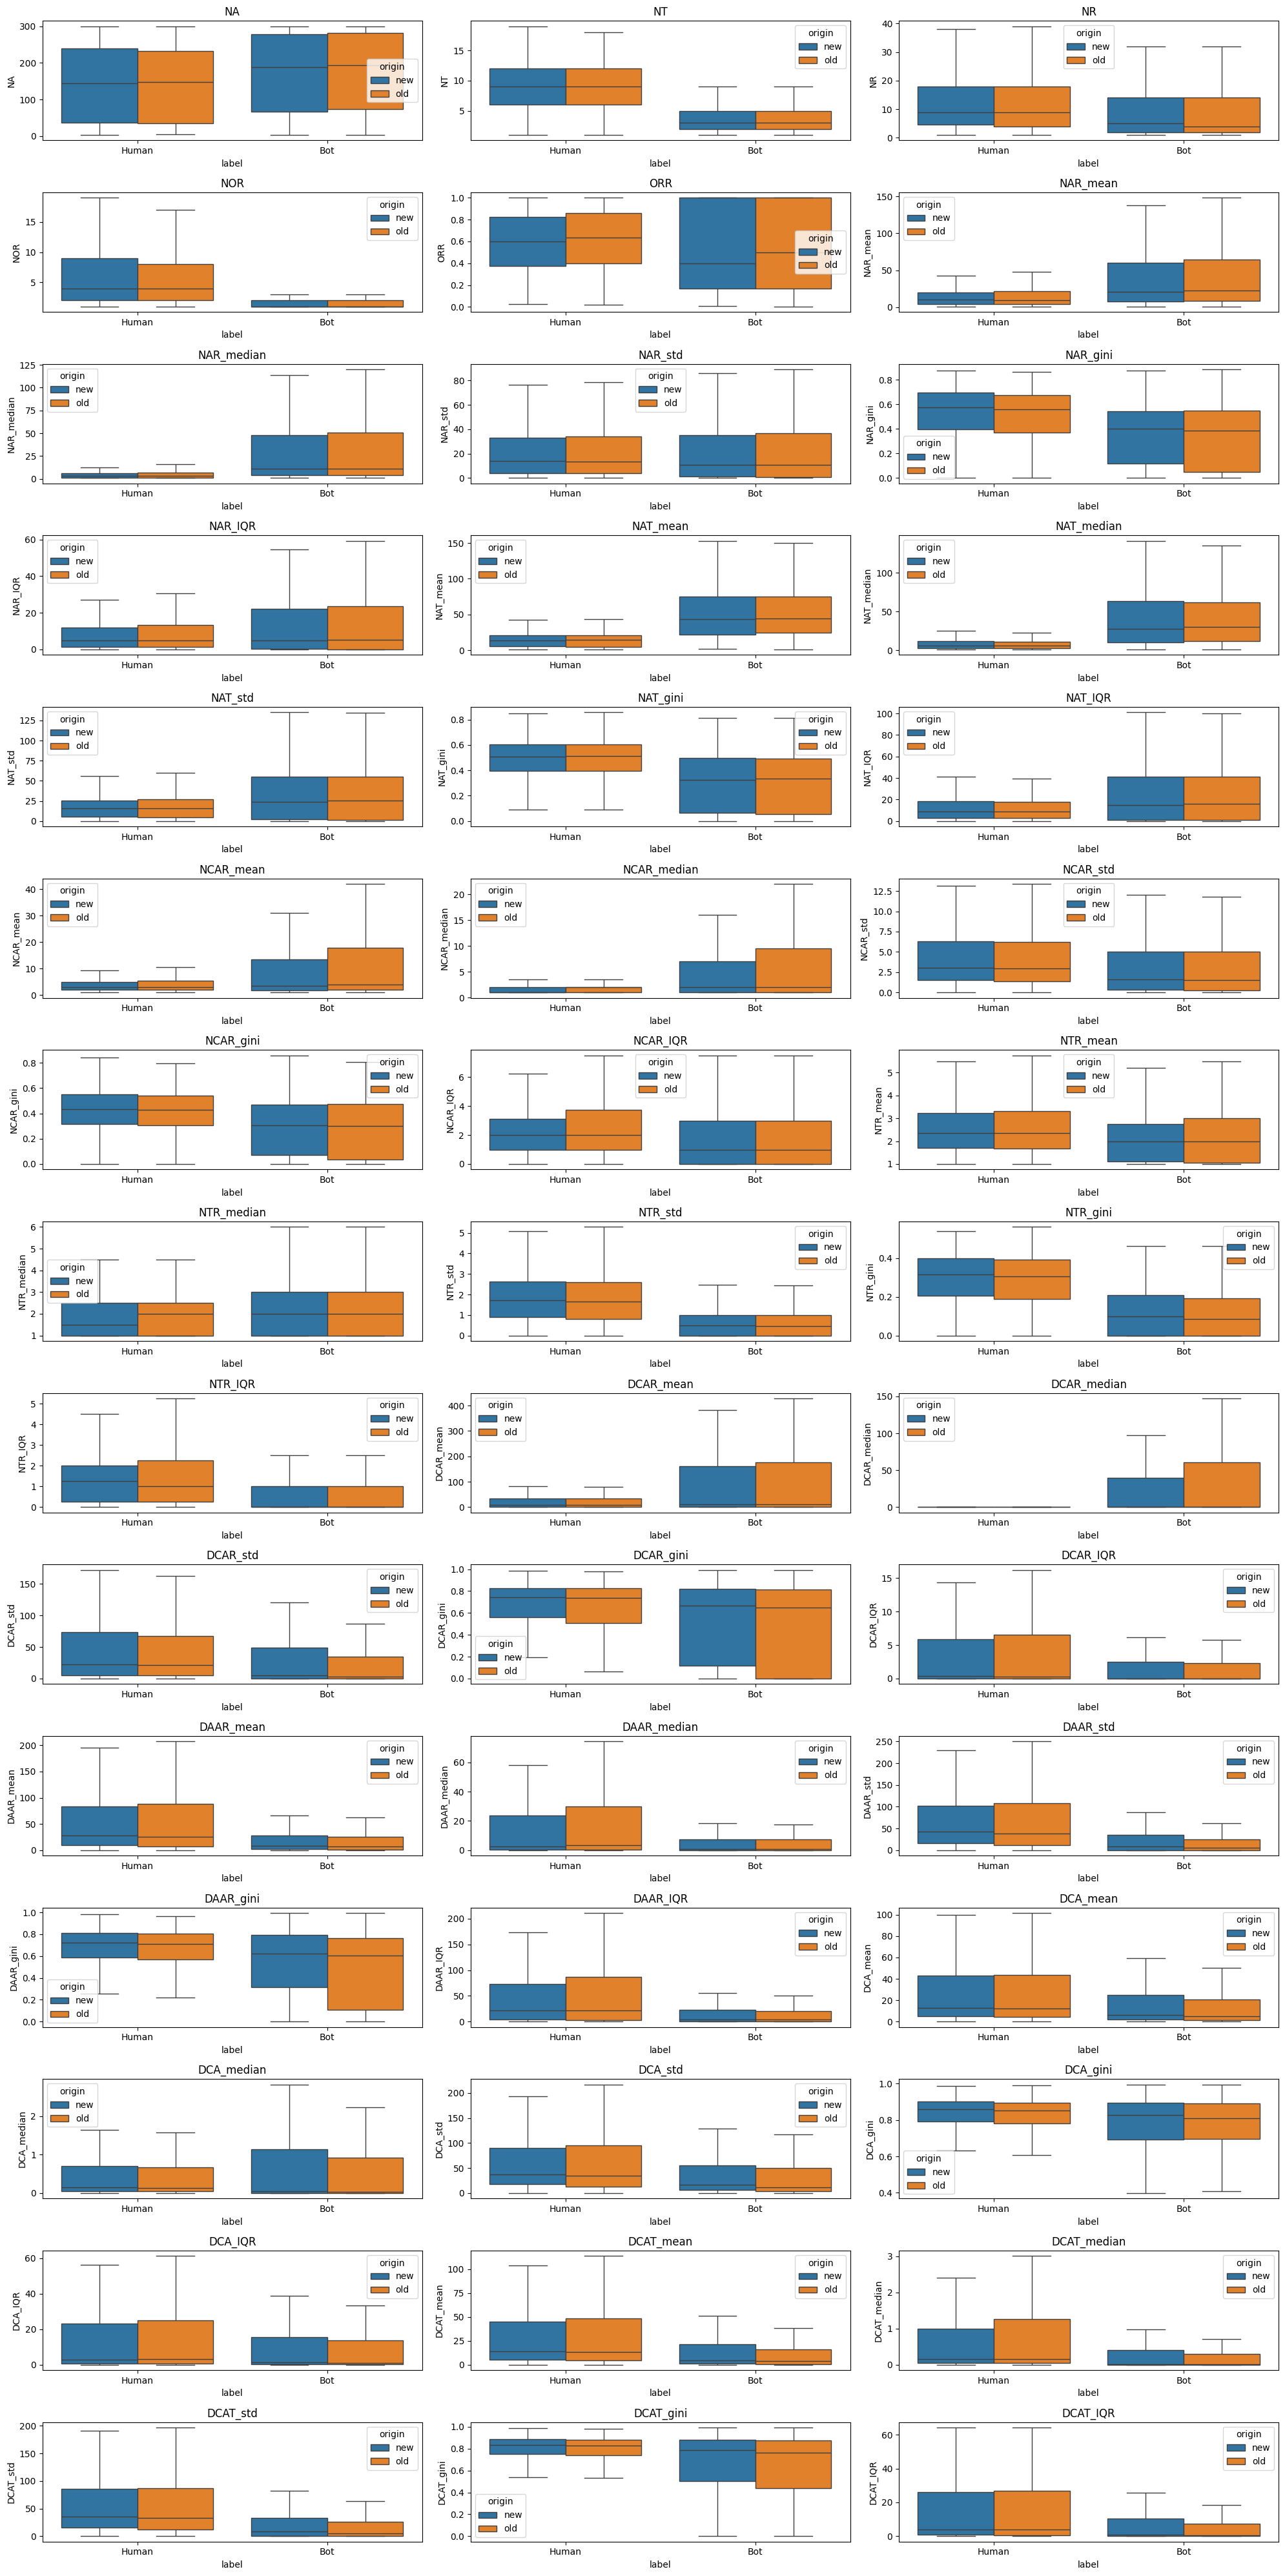

In [9]:
fig, axes = plt.subplots(15, 3, figsize=(20, 40))
for i, col in enumerate(new_features.columns[3:-1]):
    sns.boxplot(x='label', y=col, data=pd.concat([new_features, old_features], ignore_index=True), ax=axes[i//3, i%3], showfliers=False, hue='origin')
    axes[i//3, i%3].set_title(col)
plt.tight_layout()
plt.show()

# 5. Misclassified accounts

The idea is to compare the misclassified accounts to evaluate if the models predictions are similar enough or not.

TLDR; Both models misclassified 76/763 accounts but 66 of them are common to both models.
This means that the models disagree on 20 accounts ou of the 763 accounts of the dataset.

In [12]:
classified_old = pd.read_csv('../../resources/evals/github-predictions/bimbas-rbmap_predictions.csv')
classified_old['origin'] = 'old'
misclassified_old = classified_old[classified_old['true_bot'] != classified_old['predicted_bot']]
print(f"Old dataset has {len(misclassified_old)}/{len(classified_old)} misclassified accounts.")

classified_new = pd.read_csv('../../resources/evals/github-predictions/bimbaseline-rbmap_predictions.csv')
classified_new['origin'] = 'new'
misclassified_new = classified_new[classified_new['true_bot'] != classified_new['predicted_bot']]
print(f"New dataset has {len(misclassified_new)}/{len(classified_new)} misclassified accounts.")

Old dataset has 76/763 misclassified accounts.
New dataset has 76/763 misclassified accounts.


In [34]:
# Get old misclassified accounts that are not in the new dataset
old_wrong_new_good = misclassified_old[~misclassified_old['contributor'].isin(misclassified_new['contributor'])]
print(f"{len(old_wrong_new_good)} misclassified accounts in the old dataset are not in the new dataset.")
print(f"With {len(old_wrong_new_good[old_wrong_new_good['true_bot'] == 'Bot'])} bots and {len(old_wrong_new_good[old_wrong_new_good['true_bot'] == 'Human'])} humans.")
display(old_wrong_new_good)

old_good_new_wrong = misclassified_new[~misclassified_new['contributor'].isin(misclassified_old['contributor'])]
print(f"{len(old_good_new_wrong)} misclassified accounts in the new dataset are not in the old dataset.")
print(f"With {len(old_good_new_wrong[old_good_new_wrong['true_bot'] == 'Bot'])} bots and {len(old_good_new_wrong[old_good_new_wrong['true_bot'] == 'Human'])} humans.")
display(old_good_new_wrong)

10 misclassified accounts in the old dataset are not in the new dataset.
With 9 bots and 1 humans.


,contributor,true_bot,predicted_bot,confidence
40,mqube-bot,Bot,Human,0.080
161,artsyit,Bot,Human,0.307
232,opensearch-ci-bot,Bot,Human,0.333
277,aws-cdk-automation,Bot,Human,0.030
463,arduino-ci-script-bot,Bot,Human,0.276
509,ladybugbot,Bot,Human,0.157
540,nethbot,Bot,Human,0.298
596,jenkins-x-bot,Bot,Human,0.145
624,bot-gradle,Bot,Human,0.096
690,firker,Human,Bot,0.025


10 misclassified accounts in the new dataset are not in the old dataset.
With 6 bots and 4 humans.


,contributor,true_bot,predicted_bot,confidence
32,mreiferson,Human,Bot,0.171
47,bgraef,Human,Bot,0.263
198,dangerpr-bot,Bot,Human,0.284
327,sealos-ci-robot,Bot,Human,0.356
491,xprobebot,Bot,Human,0.296
492,leleuj,Human,Bot,0.246
559,riotrobot,Bot,Human,0.539
594,pralor-bot,Bot,Human,0.153
632,rakutentech-danger-bot,Bot,Human,0.265
747,vks,Human,Bot,0.273
